In [1]:
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

load the model

In [2]:
# Load the YOLOv5 trained model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='DetectionModel.pt', force_reload=False)


Using cache found in C:\Users\yushe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-5 Python-3.11.10 torch-2.3.1 CPU

Fusing layers... 
Model summary: 367 layers, 46154948 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


 Predict and visualize oner img,ca;culate height width area of wheel

         xmin        ymin         xmax        ymax  confidence  class  \
0  698.246094  700.264465   855.182312  856.877808    0.976979      0   
1  103.303078  669.466187   262.236877  823.650269    0.974967      0   
2  184.045456  590.298462   779.052307  795.821716    0.973367      5   
3  278.485077  464.314026   977.557800  619.744568    0.968690      3   
4  332.425079  484.523529   770.548218  609.908875    0.927525      4   
5   20.372168  588.909058  1016.082397  844.701477    0.902922      2   
6  725.279663  729.856934   829.438660  833.509094    0.823313      1   
7  128.821381  698.788208   232.663086  801.918335    0.646403      1   

       name  
0      tire  
1      tire  
2  bodyside  
3     cabin  
4       dlo  
5      body  
6     wheel  
7     wheel  
       height       width          area
6  103.652161  104.158997  10796.305046
7  103.130127  103.841705  10709.208253


C:\Users\yushe\AppData\Local\Temp\ipykernel_1520\3811205602.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
C:\Users\yushe\AppData\Local\Temp\ipykernel_1520\3811205602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
C:\Users\yushe\AppData\Local\Temp\ipykernel_1520\3811205602.py:19: SettingWithCopyWarning: 
A value is trying to be set

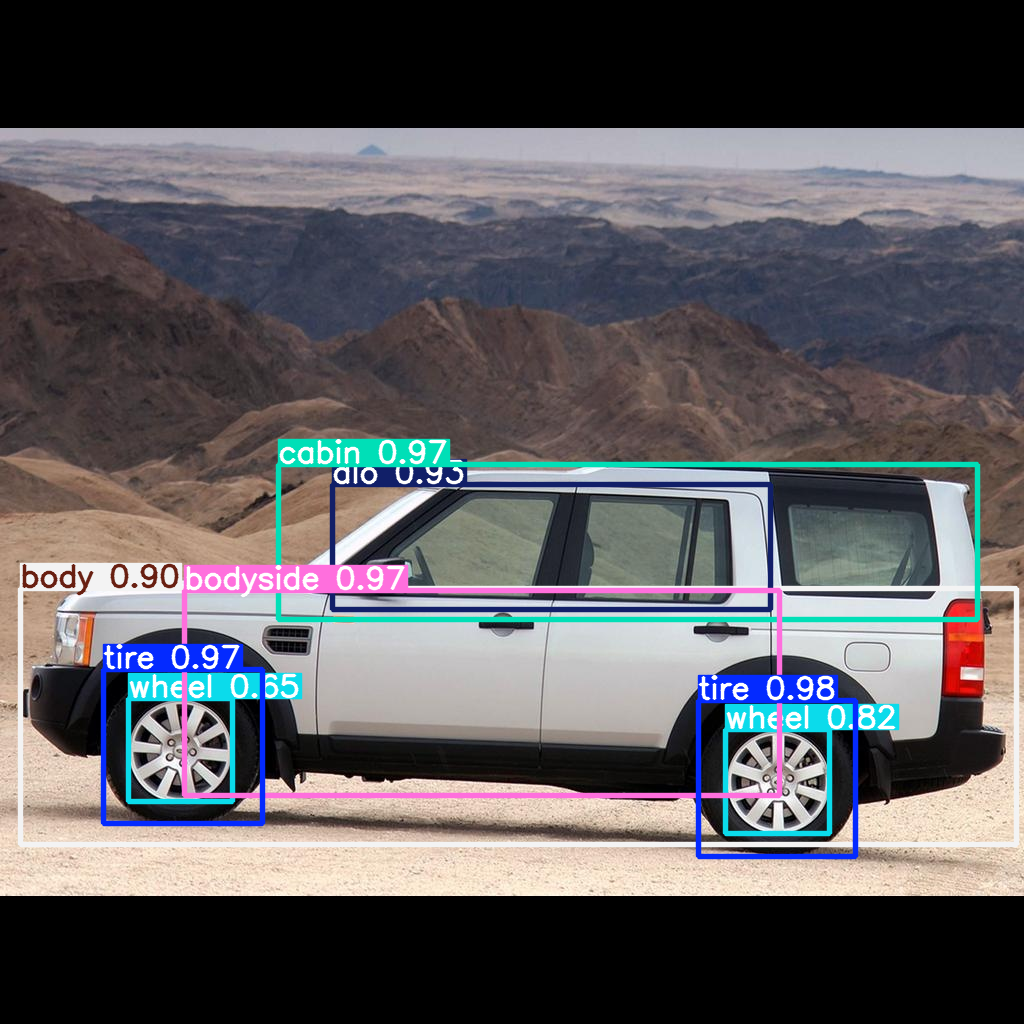

In [3]:
 #Load the image you want to predict
#image_path="..\data\split/train\images\C_Bmw_23_aug_0.jpg"
image_path="..\data\split/test\images\J_Lan_19_aug_0.jpg"
image = Image.open(image_path)

# Perform inference
results = model(image)
predictions = results.pandas().xyxy[0]  # Predictions in pandas DataFrame format
# Print results
print(results.pandas().xyxy[0])  # Predictions in pandas DataFrame format

# Filter for "wheel" class (class == 1 or name == "wheel")
wheel_predictions = predictions[predictions["name"] == "wheel"]

# Calculate the height of the wheels
if not wheel_predictions.empty:
    wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
    wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
    wheel_predictions["area"] = (wheel_predictions["xmax"] - wheel_predictions["xmin"])*(wheel_predictions["ymax"]-wheel_predictions["ymin"])
    #print("Wheel Heights:")
    print(wheel_predictions[[ "height","width","area"]])
else:
    print("No wheels detected in the image.")



# Visualize the results
results.show()

# Save the results image (optional)
#results.save(save_dir='runs/detect/')  # Save predictions to 'runs/detect/' directory


Correct tilted img from wheel angle (doesn't work for now)

In [7]:
def correct_tilt(image, wheel_boxes):
    """
    Corrects the tilt of the car by aligning the wheels horizontally.
    Args:
        image (numpy array): The input image.
        wheel_boxes (list): List of tuples [(xmin, ymin, xmax, ymax), ...] for detected wheels.
    Returns:
        numpy array: The corrected image.
    """
    
    if len(wheel_boxes) < 2:
        print("Not enough wheels detected to correct tilt.")
        return image

    # Get the centers of the first two detected wheels
    wheel_centers = [(int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2)) for box in wheel_boxes[:2]]
    p1, p2 = wheel_centers
    
    # Calculate the angle of tilt
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    angle = np.degrees(np.arctan2(dy, dx))

    # Rotate the image to correct tilt
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    print(rotation_matrix)
    print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    (h, w) = image.shape[:2]
    print(f"Width: {w}, Height: {h}")

    corrected_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    #cv2.imshow(image)
    #cv2.imshow("rotated image:", corrected_image) 
    # Use matplotlib instead of cv2.imshow
    
    return corrected_image

image_path="..\data\split/train\images\C_Bmw_23_aug_0.jpg"
def preprocess_image(image_path, model):
    """
    Detects wheels/tires using YOLOv5, corrects tilt, and returns the corrected image.
    Args:
        image_path (str): Path to the input image.
        model: The YOLOv5 model.
    Returns:
        numpy array: The corrected image.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    # Perform inference
    results = model(image_path)

    # Convert predictions to pandas DataFrame
    predictions = results.pandas().xyxy[0]

    # Filter for wheels/tires (class == 0 or class == 1 depending on your annotations)
    wheel_predictions = predictions[(predictions["name"] == "wheel") ]

    # Extract bounding boxes for wheels
    wheel_boxes = [
        (row["xmin"], row["ymin"], row["xmax"], row["ymax"])
        for _, row in wheel_predictions.iterrows()
    ]
    
    # Correct tilt using detected wheels
    corrected_image = correct_tilt(image, wheel_boxes)

    return corrected_image

corrected_image = preprocess_image(image_path, model)

print(f"Image Shape: {image.shape}")


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.title("Corrected Image")
plt.show()


[[   -0.99303    -0.11789      1080.8]
 [    0.11789    -0.99303      960.07]]
Image shape: (1024, 1024, 3), dtype: uint8
Width: 1024, Height: 1024


AttributeError: 'JpegImageFile' object has no attribute 'shape'

Predict All .jpg Images in a Folder

In [ ]:
import os
import pandas as pd

# Specify input and output folders
input_folder = "path_to_your_input_folder"  # Replace with the folder containing your .jpg images
output_folder = "path_to_your_output_folder"  # Replace with the folder to save results

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Initialize results list
all_results = []

# Loop through all .jpg files in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".jpg"):  # Process only .jpg files
        image_path = os.path.join(input_folder, file_name)

        # Load and predict the image
        results = model(image_path)  # Perform YOLO predictions
        predictions = results.pandas().xyxy[0]  # Convert predictions to pandas DataFrame

        # Filter for wheels
        wheel_predictions = predictions[predictions["name"] == "wheel"]

        # Calculate height, width, area, and position for wheels
        if not wheel_predictions.empty:
            wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
            wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
            wheel_predictions["area"] = wheel_predictions["height"] * wheel_predictions["width"]
            wheel_predictions["x_center"] = (wheel_predictions["xmin"] + wheel_predictions["xmax"]) / 2
            wheel_predictions["y_center"] = (wheel_predictions["ymin"] + wheel_predictions["ymax"]) / 2

        # Append results to the list
        for _, row in predictions.iterrows():
            result = {
                "image": file_name,
                "xmin": row["xmin"],
                "ymin": row["ymin"],
                "xmax": row["xmax"],
                "ymax": row["ymax"],
                "confidence": row["confidence"],
                "class": row["class"],
                "name": row["name"],
            }
            if row["name"] == "wheel":
                # Add wheel-specific calculations
                result["height"] = row["ymax"] - row["ymin"]
                result["width"] = row["xmax"] - row["xmin"]
                result["area"] = result["height"] * result["width"]
                result["x_center"] = (row["xmin"] + row["xmax"]) / 2
                result["y_center"] = (row["ymin"] + row["ymax"]) / 2
            else:
                # Non-wheel objects
                result["height"] = None
                result["width"] = None
                result["area"] = None
                result["x_center"] = None
                result["y_center"] = None

            all_results.append(result)

# Convert all results to a DataFrame
results_df = pd.DataFrame(all_results)

# Save the results to a CSV file
output_csv = os.path.join(output_folder, "predictions_with_wheel_dimensions.csv")
results_df.to_csv(output_csv, index=False)
print(f"Saved all results to {output_csv}")
print("Processing completed!")
